# Comparison of dgemm calls performed within HPL and in a calibration

In [1]:
import io
import os
import zipfile
import pandas
import yaml
import datetime
import re
from plotnine import *
import plotnine
plotnine.options.figure_size = (12, 8)
import warnings
warnings.simplefilter(action='ignore') # removing annoying warning
import json

def read_csv(archive_name, csv_name, columns=None, filter_func=lambda x: x):
    archive = zipfile.ZipFile(archive_name)
    df = pandas.read_csv(io.BytesIO(filter_func(archive.read(csv_name))), names=columns)
    df.columns = df.columns.str.strip()
    df['jobid'] = int(get_yaml(archive_name, 'info.yaml')['jobid'])
    df['index'] = range(len(df))
    return df

def get_yaml(archive_name, yaml_name):
    archive = zipfile.ZipFile(archive_name)
    return yaml.load(io.BytesIO(archive.read(yaml_name)))

In [2]:
archive = 'dgemm_prediction/9/grenoble_2019-10-14_1888501.zip'

def read_archive(archive_name, exp_id):
    blas_col = ['file', 'line', 'function', 'rank', 'timestamp', 'duration', 'm', 'n', 'k', 'lda', 'ldb', 'ldc', 'layout', 'transA', 'transB']
    df = read_csv(archive_name, 'trace_blas_%d.csv' % exp_id, columns=blas_col)
    print('Read trace n°%d from %s: %6d lines' % (exp_id, archive_name, len(df)))
    df['start'] = df.timestamp
    df['end'] = df.timestamp + df.duration
    df = df[['file', 'line', 'index', 'jobid', 'function', 'start', 'end', 'rank', 'm', 'n', 'k', 'lda', 'ldb', 'ldc', 'layout', 'transA', 'transB', 'duration']]
    df['function'] = df['function'].str.strip()
    df['exp_id'] = exp_id
    return df

traces = read_archive(archive, 0)

traces = traces[(traces['function'] == 'dgemm') & (traces['rank'] == 0)].reset_index(drop=True)
traces.m = traces.m.astype(int)
traces.n = traces.n.astype(int)
traces.k = traces.k.astype(int)
print(len(traces))
traces.head()

Read trace n°0 from dgemm_prediction/9/grenoble_2019-10-14_1888501.zip: 250682 lines
7886


,file,line,index,jobid,function,start,end,rank,m,n,k,lda,ldb,ldc,layout,transA,transB,duration,exp_id
0,../HPL_pdrpanrlT.c,224,1,1888501,dgemm,0.000971,0.001015,0,7678,2,2,NaN,NaN,NaN,NaN,NaN,NaN,0.000044,0
1,../HPL_pdrpanrlT.c,224,2,1888501,dgemm,0.001186,0.001248,0,7676,4,4,NaN,NaN,NaN,NaN,NaN,NaN,0.000062,0
2,../HPL_pdrpanrlT.c,224,3,1888501,dgemm,0.001378,0.001403,0,7674,2,2,NaN,NaN,NaN,NaN,NaN,NaN,0.000025,0
3,../HPL_pdrpanrlT.c,224,4,1888501,dgemm,0.001536,0.001678,0,7672,8,8,NaN,NaN,NaN,NaN,NaN,NaN,0.000142,0
4,../HPL_pdrpanrlT.c,224,5,1888501,dgemm,0.001827,0.001853,0,7670,2,2,NaN,NaN,NaN,NaN,NaN,NaN,0.000026,0


In [3]:
traces['mnk'] = traces.m * traces.n * traces.k
traces['special'] = (traces.m == 2048) & (traces.n == 2048) & (traces.k == 2048)
traces['gflops'] = 2*traces.mnk / traces['duration'] * 1e-9

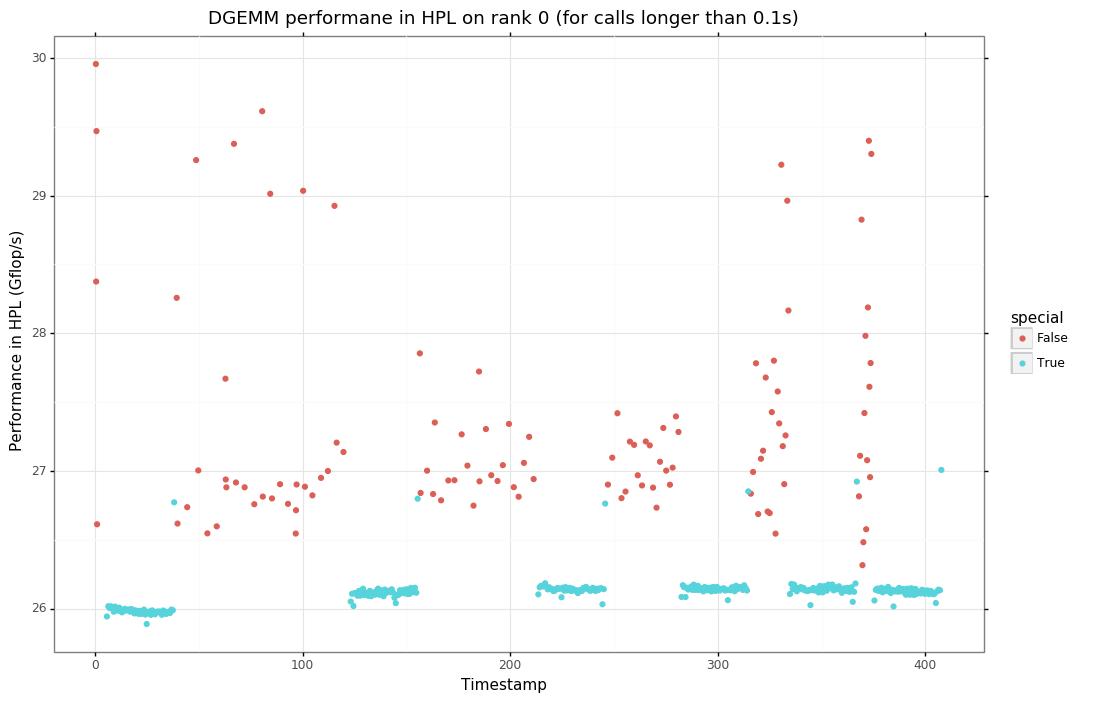

<ggplot: (-9223363258393670214)>

In [4]:
plot = ggplot(traces[traces.duration > 0.1], aes(x='start', y='gflops', color='special')) + geom_point() + theme_bw()
plot = plot + xlab('Timestamp') + ylab('Performance in HPL (Gflop/s)') + ggtitle('DGEMM performane in HPL on rank 0 (for calls longer than 0.1s)')
plot

## Monitoring

In [5]:
def get_monitoring(archive_name, csv_name, tag):
    df = read_csv(archive_name, csv_name)
    for col in ['start', 'stop']:
        df[col] = pandas.to_datetime(df[col])
    first = df['start'].min()
    df['start'] -= first
    df['stop'] -= first
    df['tag'] = tag
    return df

In [6]:
temperature = pandas.concat([
    get_monitoring(archive, 'monitoring_temp.csv', tag='HPL'),
])
temperature.head()

,hostname,start,stop,sensor_id,temperature,jobid,index,tag
0,dahu-23.grenoble.grid5000.fr,00:00:00,00:00:00.000175,0,75.0,1888501,0,HPL
1,dahu-23.grenoble.grid5000.fr,00:00:00,00:00:00.000175,1,53.0,1888501,1,HPL
2,dahu-23.grenoble.grid5000.fr,00:00:01.002935,00:00:01.003315,0,76.0,1888501,2,HPL
3,dahu-23.grenoble.grid5000.fr,00:00:01.002935,00:00:01.003315,1,61.0,1888501,3,HPL
4,dahu-23.grenoble.grid5000.fr,00:00:02.006169,00:00:02.006392,0,77.0,1888501,4,HPL


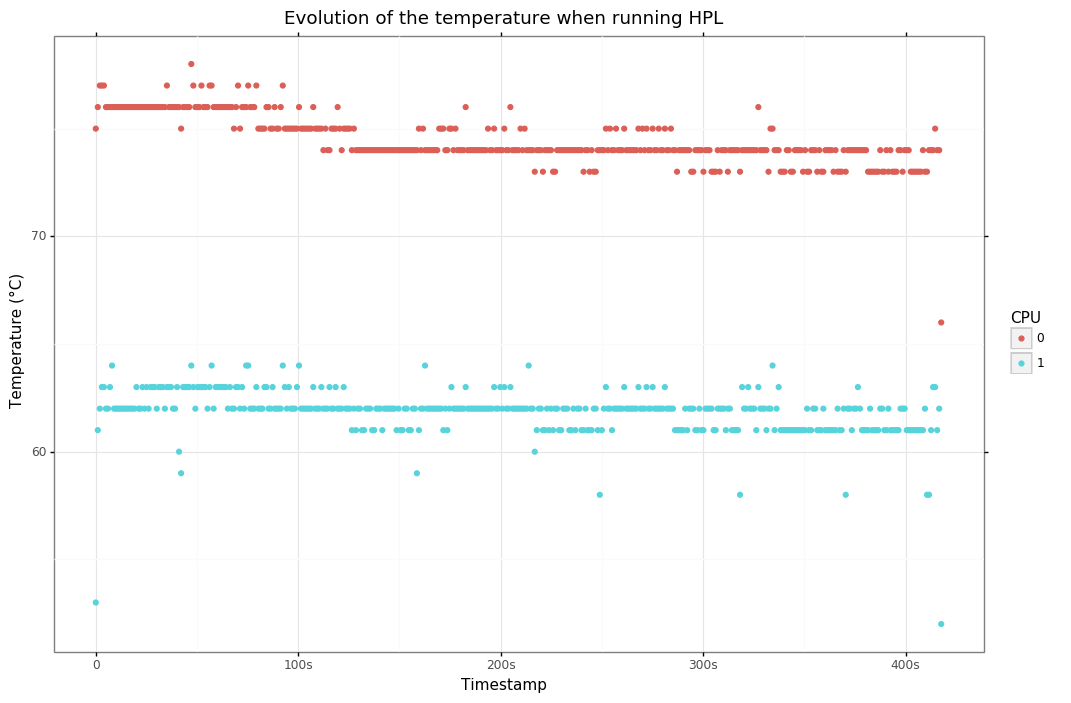

<ggplot: (8778461192445)>

In [7]:
plot = ggplot(temperature, aes(x='start', y='temperature', color='factor(sensor_id)')) + geom_point() + theme_bw()
plot = plot + xlab('Timestamp') + ylab('Temperature (°C)') + labs(color='CPU') + ggtitle('Evolution of the temperature when running HPL')
plot

In [8]:
frequency = pandas.concat([
    get_monitoring(archive, 'monitoring_freq.csv', tag='HPL'),
])
frequency['frequency'] *= 1e-9
frequency.head()

,hostname,start,stop,core_id,frequency,jobid,index,tag
0,dahu-23.grenoble.grid5000.fr,0 days,00:00:00.001516,0,1.362103,1888501,0,HPL
1,dahu-23.grenoble.grid5000.fr,0 days,00:00:00.001516,1,2.799957,1888501,1,HPL
2,dahu-23.grenoble.grid5000.fr,0 days,00:00:00.001516,2,2.175750,1888501,2,HPL
3,dahu-23.grenoble.grid5000.fr,0 days,00:00:00.001516,3,2.785986,1888501,3,HPL
4,dahu-23.grenoble.grid5000.fr,0 days,00:00:00.001516,4,1.000268,1888501,4,HPL


In [9]:
frequency['cpu_id'] = frequency['core_id'] % 2
frequency = frequency[frequency['core_id'] < 32]  # removing the hyperthread cores

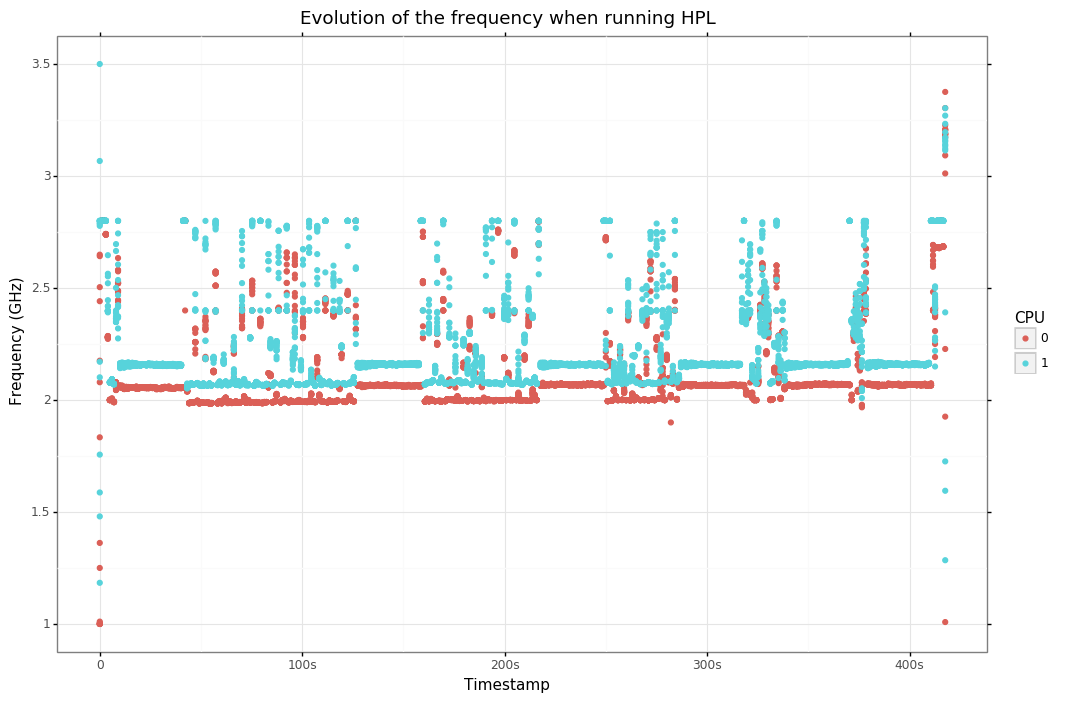

<ggplot: (-9223363258393564251)>

In [10]:
plot = ggplot(frequency, aes(x='start', y='frequency', color='factor(cpu_id)')) + geom_point() + theme_bw()
plot = plot + xlab('Timestamp') + ylab('Frequency (GHz)') + labs(color='CPU') + ggtitle('Evolution of the frequency when running HPL')
plot

In [11]:
special_dgemm = traces[traces.special]
start = special_dgemm[special_dgemm.start > 100].start.min()
stop = special_dgemm[special_dgemm.end < 160].end.max()
print('Second special dgemm phase: %.2fs - %.2fs' % (start, stop))
start_window = pandas.to_timedelta(start-20, unit='s')
stop_window = pandas.to_timedelta(stop+20, unit='s')
start = pandas.to_timedelta(start, unit='s')
stop = pandas.to_timedelta(stop, unit='s')

Second special dgemm phase: 123.18s - 156.06s


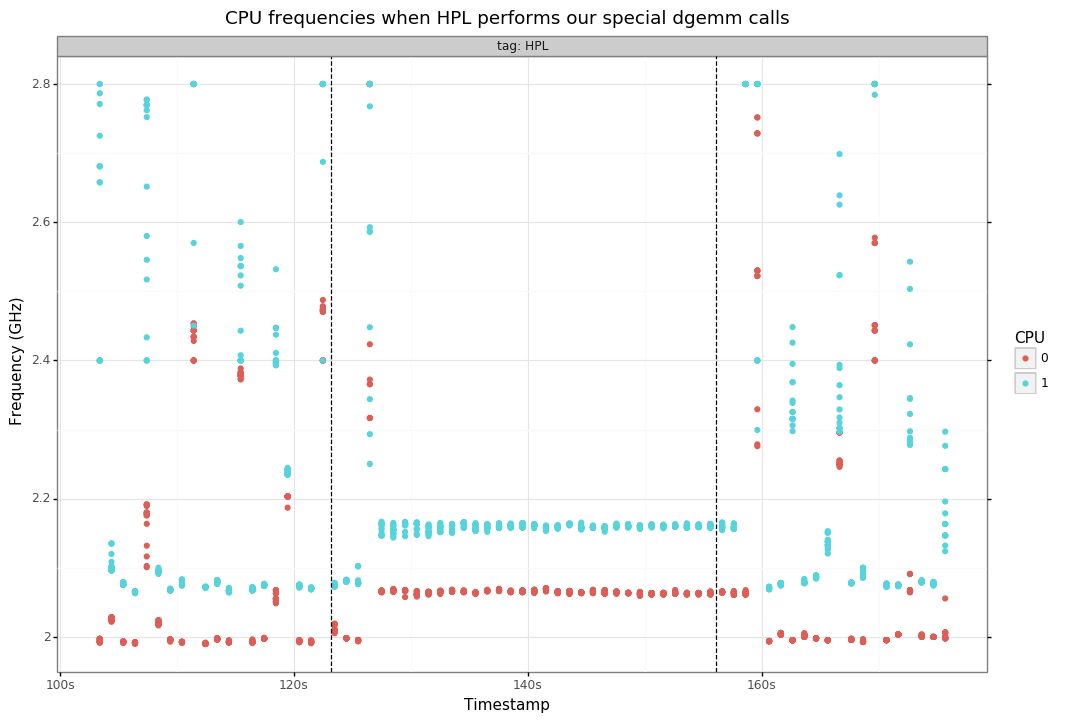

<ggplot: (8778461180687)>

In [12]:
plot = ggplot(frequency[(frequency.start >= start_window) & (frequency.start <= stop_window) & (frequency.tag == 'HPL')], aes(x='start', y='frequency', color='factor(cpu_id)')) 
plot = plot + geom_point() + theme_bw() +  facet_wrap('tag', labeller='label_both')
plot = plot + geom_vline(xintercept=start, linetype='dashed') + geom_vline(xintercept=stop, linetype='dashed')
plot = plot + xlab('Timestamp') + ylab('Frequency (GHz)') + labs(color='CPU')
plot + ggtitle('CPU frequencies when HPL performs our special dgemm calls')

In [13]:
dump = traces[(traces['rank'] == 0)].sort_values(by='index', axis=0)[['function', 'm', 'n', 'k']]
dump.m = dump.m.astype('int')
dump.n = dump.n.astype('int')
dump.k = dump.k.astype('int')
dump.to_csv('/tmp/exp_hpl.csv', index=False, header=False)